# Project :  Predicting Used Car Prices in Virginia using Machine Learning

### 1. Data Introduce
### 1.1 Purpose : Predict SalePrice
### 1.2 Data set:
- Collect Used Car data from Cars.com 
- Total Data : It consists of 14 variables and 1460 Used Car data

### 1.3 Evaluation
   > - Root-Mean-Squared-Error (RMSE)  

$$
RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}
$$



### 1. Exploring the Data
Let's start with importing the necessary libaries, reading in the data and checking out the dataset.

In [1]:
import pandas as pd
import numpy as np
import re
import pymysql, pickle
import matplotlib.pyplot as plt
from collections import Counter

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from warnings import filterwarnings

filterwarnings("ignore", category=UserWarning)

def load_data():

    # Read Password

    pw = pickle.load(open('./Flask/pickle/pw.pkl', 'rb'))
    host_ = pickle.load(open('./Flask/pickle/host.pkl', 'rb')) 
    
    # AWS MySql Connection Info
    db = pymysql.connect(
        host = host_,
        user = "root",
        password = pw,
        db = "usedcar",
        charset='utf8',
    )

    SQL_QUERY = """
        SELECT *
        FROM usedcar;
    """

    train = pd.read_sql(SQL_QUERY, db)
    pickle.dump(train, open("./Flask/pickle/database.pkl", "wb"))
    
    return train

pw = pickle.load(open('./Flask/pickle/pw.pkl', 'rb'))
host_ = pickle.load(open('./Flask/pickle/host.pkl', 'rb')) 

# AWS MySql Connection Info
db = pymysql.connect(
    host = host_,
    user = "root",
    password = pw,
    db = "usedcar",
    charset='utf8',
)

SQL_QUERY = """
    SELECT *
    FROM usedcar;
"""

train = pd.read_sql(SQL_QUERY, db)
pickle.dump(train, open("./Flask/pickle/database.pkl", "wb"))

## 1. Load data

The stored data retrieved through data crawling is loaded into a DataFrame

In [2]:
train = pickle.load(open('./Flask/pickle/database.pkl', 'rb')) 

### (1) Check data

In [3]:
print(f'There are {train.shape[0]} rows and {train.shape[1]} columns') 

There are 46924 rows and 16 columns


#### Comments :
There are 46924 instances of data and its number of attributes equals 16

### (2) Check data type

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46924 entries, 0 to 46923
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           46924 non-null  int64 
 1   ID              46924 non-null  object
 2   Year            46924 non-null  int64 
 3   Brand           46924 non-null  object
 4   Model           46924 non-null  object
 5   Mileage         46924 non-null  int64 
 6   Bodystyle       46545 non-null  object
 7   Dealer          45700 non-null  object
 8   Exterior Color  46924 non-null  object
 9   Interior Color  46923 non-null  object
 10  Drivetrain      46924 non-null  object
 11  MPG             46924 non-null  object
 12  Fuel Type       46924 non-null  object
 13  Transmission    46924 non-null  object
 14  Engine          46924 non-null  object
 15  Price           46924 non-null  int64 
dtypes: int64(4), object(12)
memory usage: 5.7+ MB


#### Comments :

Out of a total of 16 columns, 4 are of type int64, while the remaining 12 are of type object. The total number of data entries is 46924, and it can be observed that Bodystyle, Dealer, and Interior Color have some missing values.

### (3) Status of Train data

In [5]:
train.describe()

,index,Year,Mileage,Price
count,46924.000000,46924.000000,46924.000000,4.692400e+04
mean,3205.419657,2016.172769,62118.963707,4.035456e+04
std,2293.697892,7.413188,50519.289211,7.761011e+04
min,0.000000,1937.000000,0.000000,2.432000e+03
25%,1248.000000,2014.000000,22556.000000,1.476800e+04
50%,2809.000000,2018.000000,50650.000000,2.500000e+04
75%,4835.000000,2021.000000,91468.000000,4.064900e+04
max,12424.000000,2024.000000,369197.000000,3.599000e+06


#### Comments :

There are no missing data in the numerical columns, and the oldest car was produced in 1937. The lowest price for a vehicle can be confirmed to be around $2,432.

## 2. Data Cleaning

### (1) Remove duplicate data using ID

The ID column is a combination of Year, Brand, Model, Mileage, and Dealer and was created to delete duplicate data. Now delete duplicate data using this column data

In [6]:
train = train.drop_duplicates(['ID']).reset_index(drop=True)
print(f'There are {train.shape[0]} rows and {train.shape[1]} columns') 

There are 4898 rows and 16 columns


#### Comments :

All duplicate data was deleted, leaving only 4898 out of 46924 data.
Since small data will affect performance when creating machine learning models later, I need to think about how to solve this problem.

### (2) Check the missing values

In [7]:
import missingno as msno 

<Axes: >

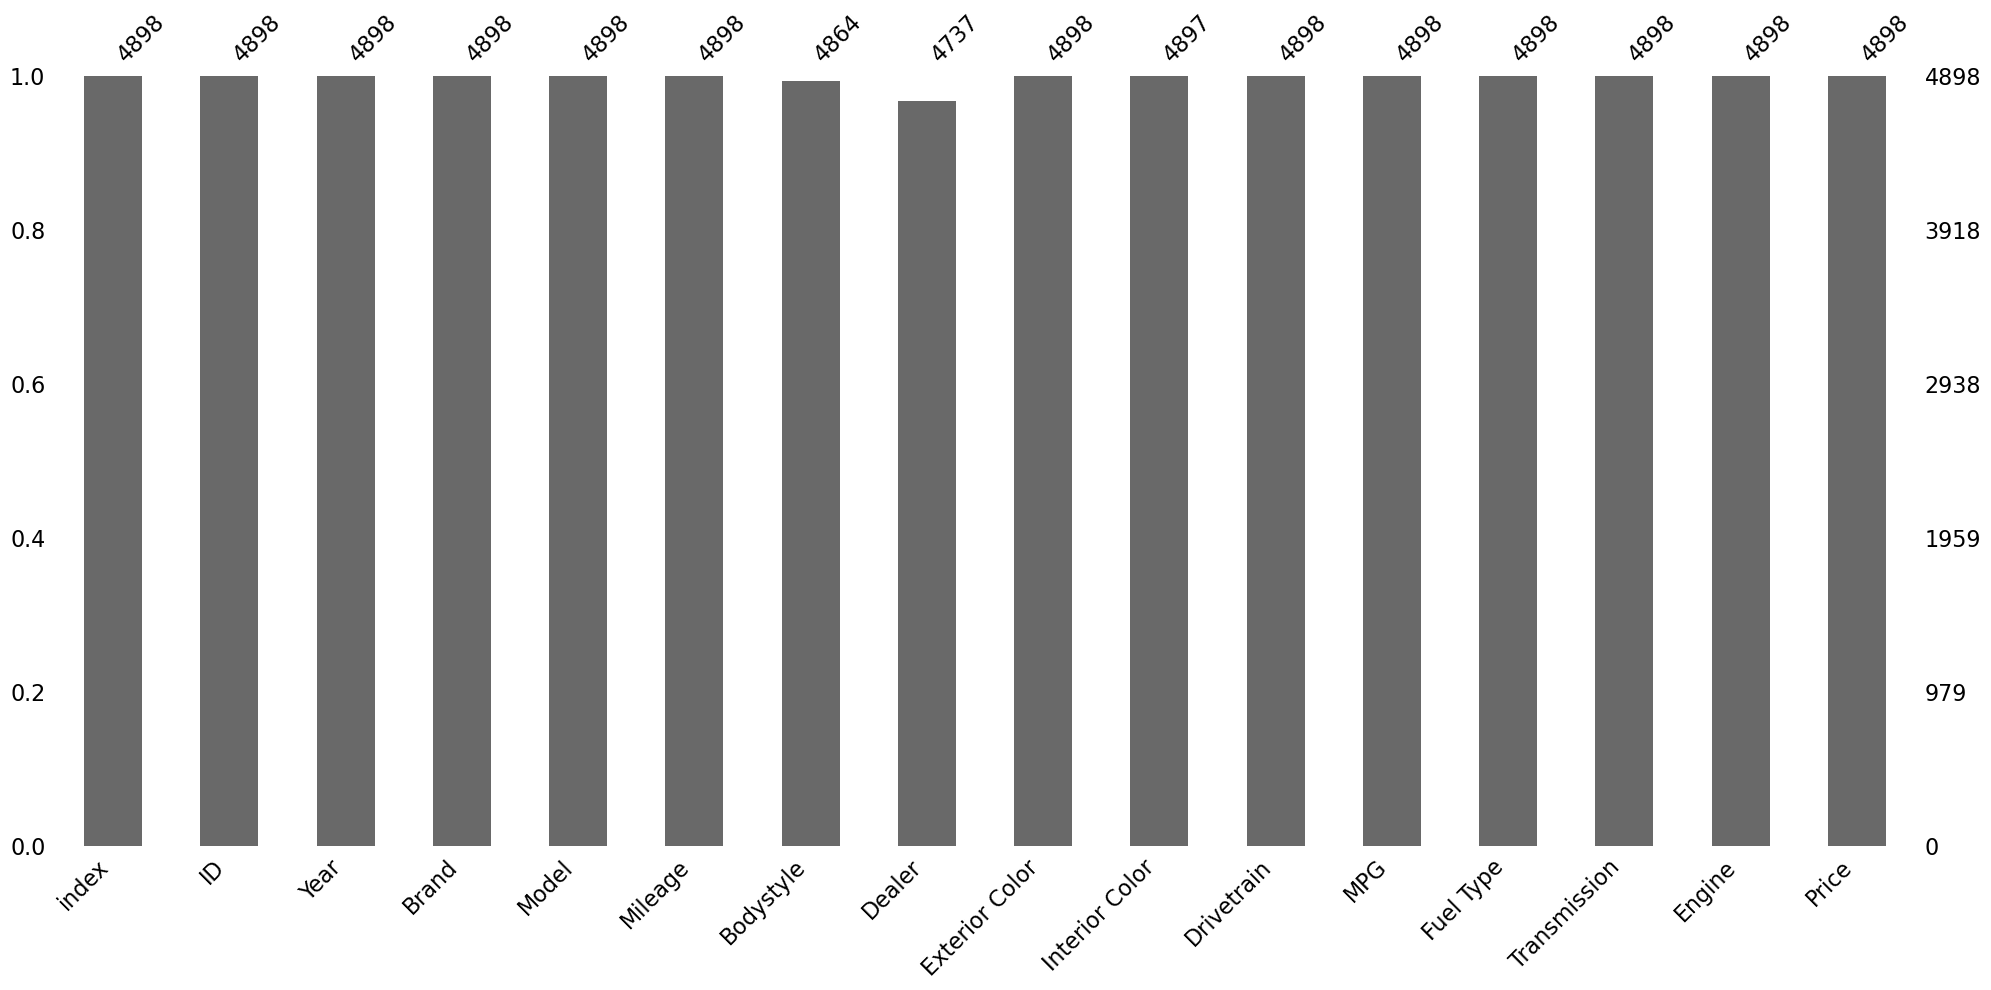

In [8]:
#Visualize missing values
msno.bar(train)

#### Comments :

It has been confirmed that there is missing data in Bodystyle and Dealer Interior Color, and it is necessary to add appropriate data in the future.

### (3) Delete unnecessary columns

Need to remove the unnecessary index column used along with the ID for deleting duplicate data during data analysis. The index was created when the data was stored in MySQL, and during the process of loading the data into the DataFrame, the index was created as a separate column in the DataFrame. This information is irrelevant to the data and needs to be removed.

In [9]:
train = train.drop(columns=['ID','index']).reset_index(drop=True)

### (4) Find and remove the outliers

The outliers could compromise the predictive power of the model. Using the quartile method, outliers in the prices of used cars were identified and removed.

In [10]:
import pandas as pd

# Identifying outliers
Q1 = train['Price'].quantile(0.25)
Q3 = train['Price'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

count_lower_bound = len(train[train['Price'] < lower_bound])
print("Lower Bound Price : ", lower_bound)
print("Number of cars priced below lower_bound :", count_lower_bound)
print("")


count_upper_bound = len(train[train['Price'] > upper_bound])
print("Upper Bound Price : ", upper_bound)
print("Number of cars priced above upper_bound :", count_upper_bound)
print("")

outliers = train[(train['Price'] < lower_bound) | (train['Price'] > upper_bound)]
outlier_prices = outliers['Price']
print("Number of outliers:", len(outlier_prices))


# Delete rows containing outliers.
train = train[~train['Price'].isin(outlier_prices)]

# Check the data after deletion.
print("Total number of rows after removing outliers:", len(train))

Lower Bound Price :  -20593.5
Number of cars priced below lower_bound : 0

Upper Bound Price :  76722.5
Number of cars priced above upper_bound : 419

Number of outliers: 419
Total number of rows after removing outliers: 4479


## 3. Exploratory Data Analysis (EDA)

### 3-1 An examination of price trend

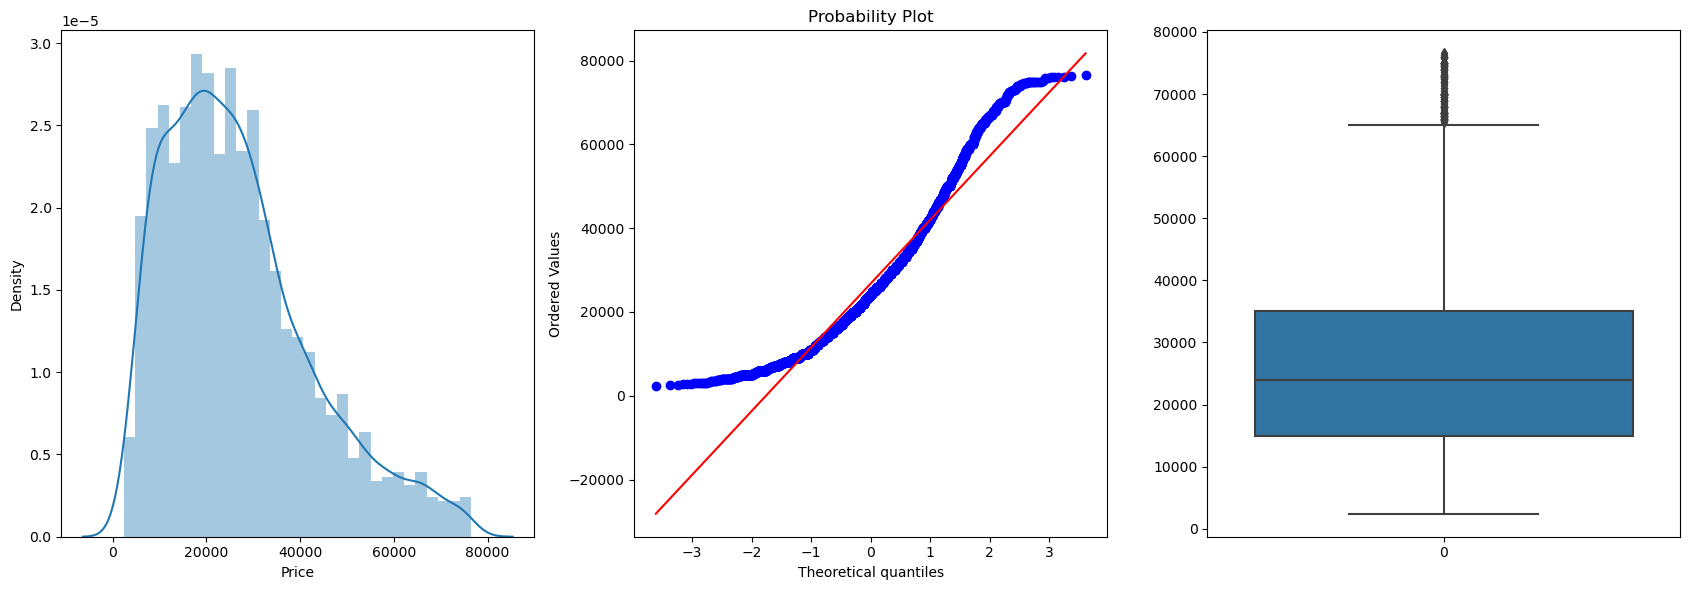

count     4479.000000
mean     26779.188212
std      15714.309215
min       2432.000000
25%      14950.000000
50%      23998.000000
75%      34995.000000
max      76557.000000
Name: Price, dtype: float64 

Skewness: 0.888484
Kurtosis: 0.377538


In [11]:
from scipy import stats
import seaborn as sns

plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(train["Price"])

plt.subplot(132)
stats.probplot(train["Price"], plot=plt)

plt.subplot(133)
sns.boxplot(train["Price"])
plt.tight_layout()
plt.show()

print(train["Price"].describe(),"\n")

print("Skewness: %f" % train['Price'].skew())
print("Kurtosis: %f" % train['Price'].kurt())

#### Comments :

It is apparent that used car price doesn't follow normal distribution and has positive skewness. The distribution of used car prices exhibits slight asymmetry, with a skewness of 0.88 and a kurtosis of 0.37. 

Most of the data is concentrated on the left side, forming a long tail on the right side. And its mean price is $26,779, with the lowest price being $2,432 and the highest price being $76,557

### Normalized price

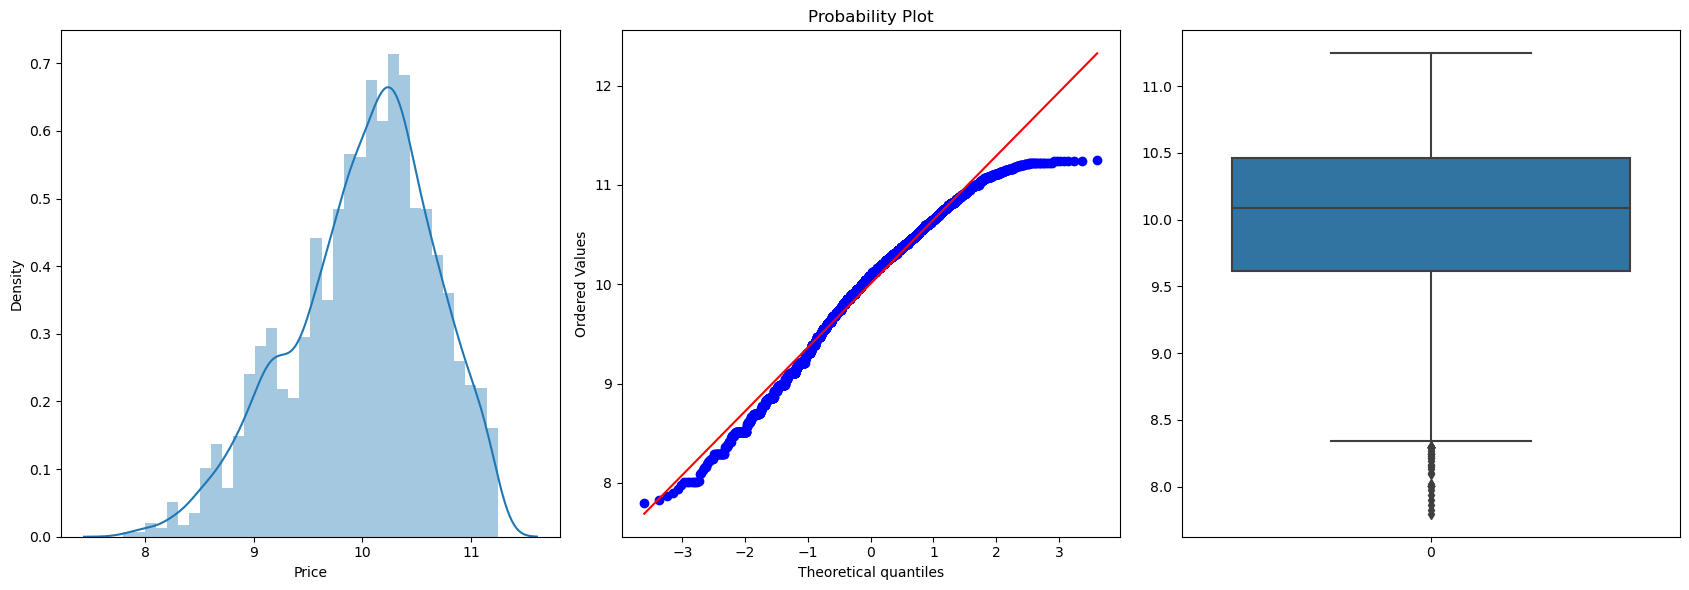

count    4479.000000
mean       10.007320
std         0.648500
min         7.796880
25%         9.612533
50%        10.085767
75%        10.462989
max        11.245804
Name: Price, dtype: float64 

Skewness: -0.484131
Kurtosis: -0.153538


In [12]:
nomalized_Price = np.log1p(train["Price"])

plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(nomalized_Price)

plt.subplot(132)
stats.probplot(nomalized_Price, plot=plt)

plt.subplot(133)
sns.boxplot(nomalized_Price)
plt.tight_layout()
plt.show()

print(nomalized_Price.describe(),"\n")

print("Skewness: %f" % nomalized_Price.skew())
print("Kurtosis: %f" % nomalized_Price.kurt())

#### Comments :

Applying the logarithm transforms the used car prices into a more normalized distribution. The reason for using natural logarithm transformation is to alleviate the skewness effect in the data. By taking the logarithm of the used car prices, it compresses the scale of the data, mitigates the influence of extreme values, and makes the distribution more symmetrical. The used car prices transformed in this way are used later when building the model.

### 3-2 Relationship between features and price
### 3-2-1 Year and Price

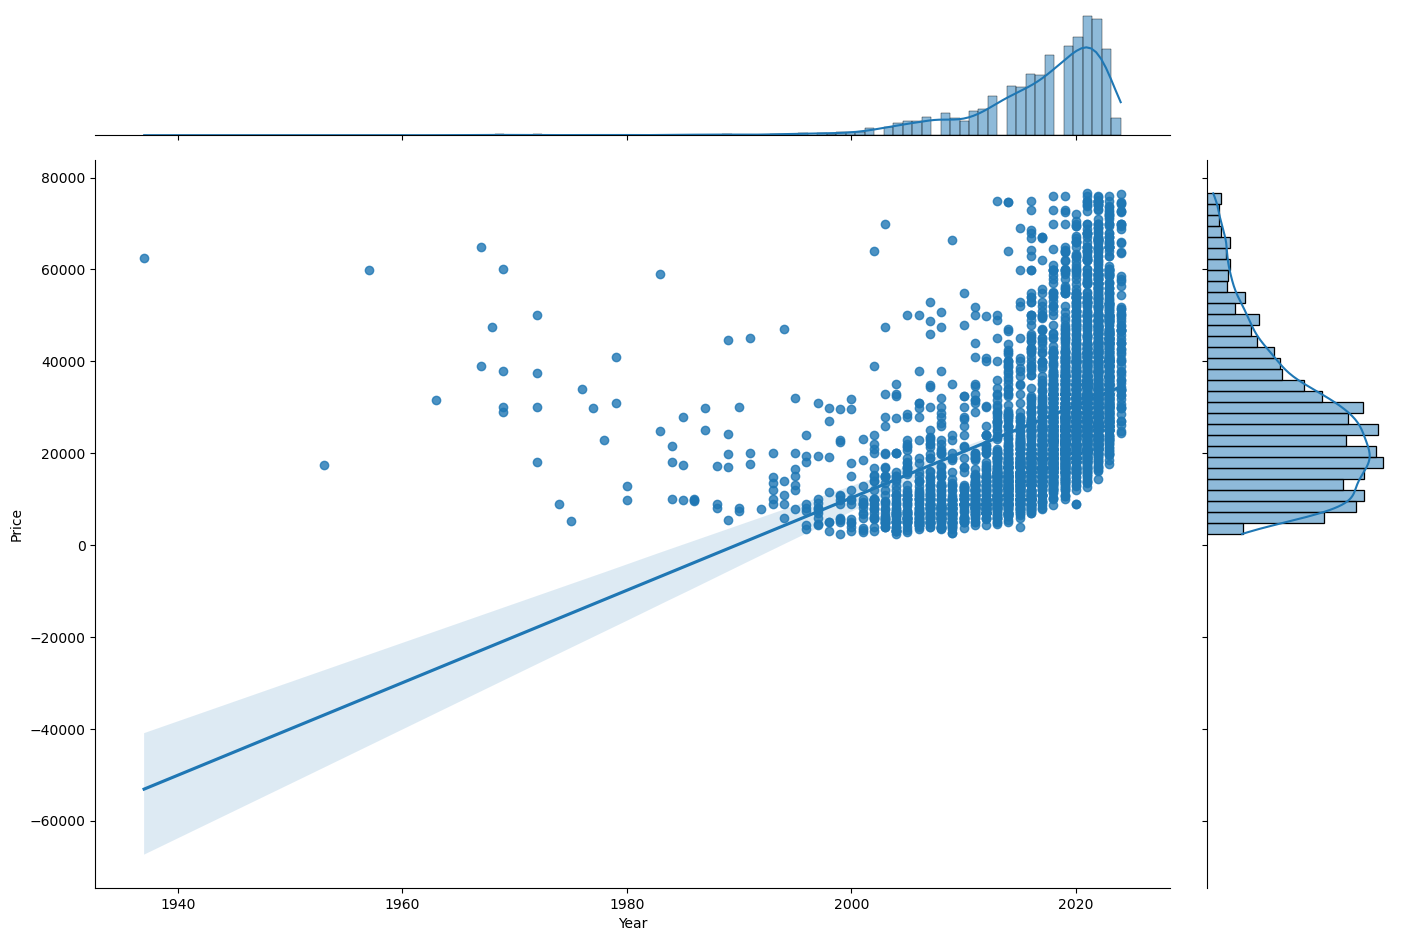

In [13]:
# Joint plot GrLivArea/saleprice
grid = sns.jointplot(x = "Year", y = "Price", data=train, kind="reg")
grid.fig.set_size_inches(15,10)

#### Comments :

It shows a positive correlation. The more recent the year, the prices tend to be higher.

In [14]:
filtered_data = train[(train['Year'] <= 1989) & (train['Price'] >= 50000)]
sorted_filtered_data = filtered_data.sort_values(by='Year', ascending=True).reset_index(drop=True)
sorted_filtered_data

,Year,Brand,Model,Mileage,Bodystyle,Dealer,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine,Price
0,1937,ford,coupe,12065,coupe,exotic car trader,orange/red,tan/red,rear-wheel,0–0,gasoline,automatic,350ci v8,62500
1,1957,porsche,356,5473,convertible,daniel schmitt & company,ivory,blue,rear-wheel,0,gasoline,4-speed manual,1.9l flat-4,59900
2,1967,chevrolet,chevelle,61658,None,joe basil chevrolet,blue,–,–,–,–,–,–,64957
3,1969,mercedes_benz,280se,103824,convertible,mcginty motorcars,tan,brown,rear-wheel,0–0,gasoline,3 speed automatic,i-6 cyl,59996
4,1983,jeep,cj,2609,suv,gateway classic cars,black,black,–,0–0,–,th350 automatic,chevy 350 v8,59000


#### Comments :

After researching cars that maintain high prices despite their age, I found five vehicles. They were produced before the 1990s and cost more than 50,000. In particular, a 1937 Ford coupe topped the list with a price of 62,500 followed by the 1957 Porsche 356 model at 59,900

In [15]:
train = train.drop(filtered_data.index)
filtered_data = train[(train['Year'] <= 1989) & (train['Price'] >= 50000)]

### 3-2-2 Mileage and Price

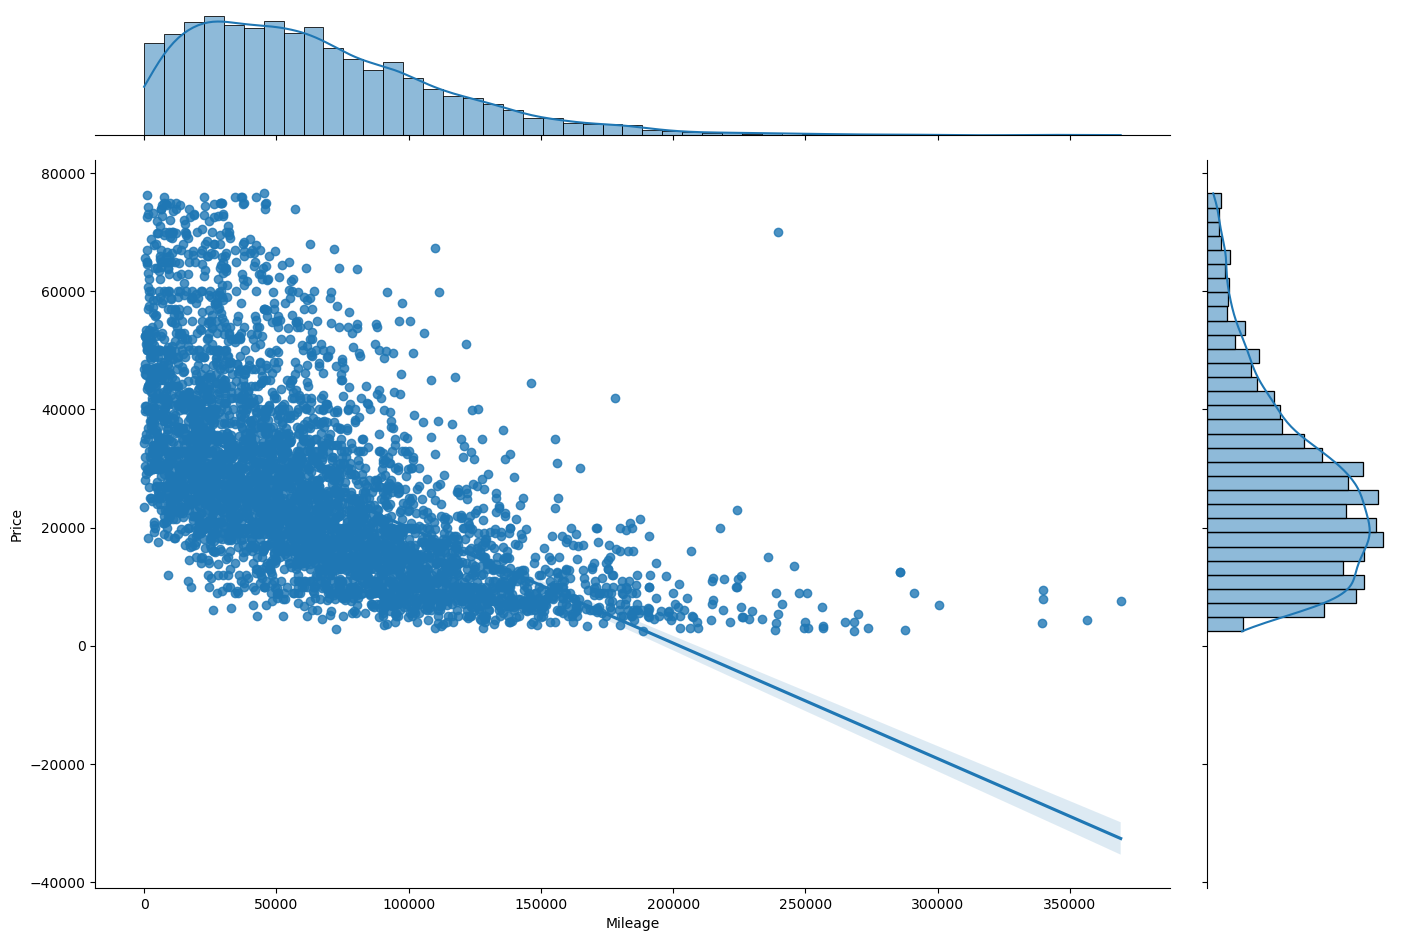

In [16]:
# Joint plot GrLivArea/saleprice
grid = sns.jointplot(x = "Mileage", y = "Price", data=train, kind="reg")
grid.fig.set_size_inches(15,10)

#### Comments :

Look into how used car prices vary depending on mileage. Found as expected Generally the lower the mileage the higher the price.

In [17]:
filtered_data = train[(train['Mileage'] > 200000) & (train['Price'] >= 60000)]
sorted_filtered_data = filtered_data.sort_values(by='Mileage', ascending=True).reset_index(drop=True)
sorted_filtered_data

,Year,Brand,Model,Mileage,Bodystyle,Dealer,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine,Price
0,2003,ford,excursion,239470,suv,east dallas diesel,other,–,four-wheel,–,diesel,5-speed automatic,6.0l v8 32v ddi ohv turbo diesel,69992


#### Comments :

There is a instance in the data where prices exceed 60,000 even with mileage exceeding 200,000. Upon reviewing the data, it was found that a Ford Excursion model from 2003, with mileage exceeding 230,000, had a price of 69,992. This data was removed from the train dataset as it could influence the prediction of used car prices

In [18]:
train = train.drop(filtered_data.index)
filtered_data = train[(train['Mileage'] > 200000) & (train['Price'] >= 60000)]

### 3-2-3 Brand and Price

### Number of vehicles by brand

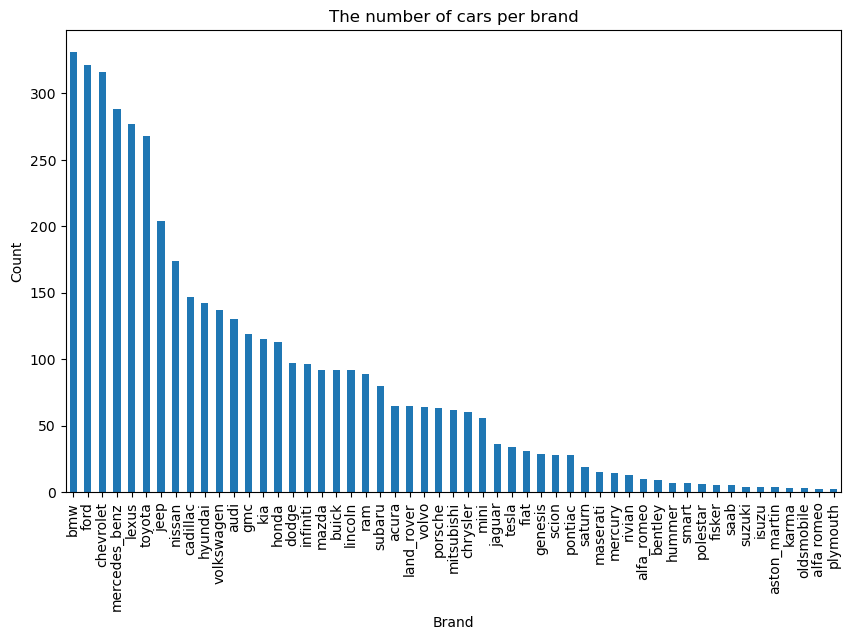

In [19]:
# Count the total number for each brand in the train data
brand_counts = train['Brand'].value_counts()

# Sort by most 
brand_counts_sorted = brand_counts.sort_values(ascending=False)

# Drawing graphs
plt.figure(figsize=(10, 6))
brand_counts_sorted.plot(kind='bar')
plt.title('The number of cars per brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


#### Comments :

BMW, Ford, Chevrolet, Benz, etc., are seen to have appeared frequently.

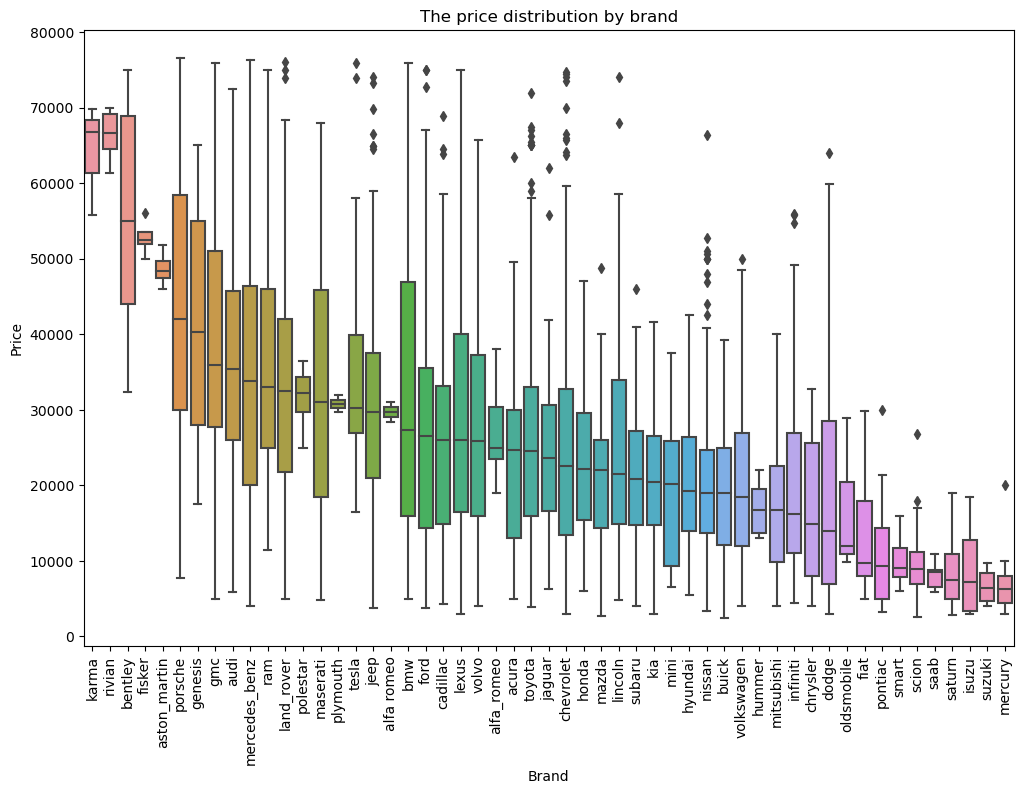

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort brands by highest price distribution
sorted_brands = train.groupby('Brand')['Price'].median().sort_values(ascending=False).index

# Drawing a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Brand', y='Price', data=train, order=sorted_brands)
plt.title('The price distribution by brand')
plt.xlabel('Brand')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()


#### Comments :

Karma, Rivian, and Fisker are maintaining the highest price ranges, and these three companies are electric car 
manufacturers. Another electric car, Tesla, also maintains a high price range of around 30,000 to 40,000. Additionally, luxury car brands like Bentley, Aston Martin, and Porsche also show high prices. Since the price distribution is generally well spread out by brand, believe that considering the brand will be helpful in predicting prices when building future models

### 3-2-4 Model and Price

### Number of vehicles by model

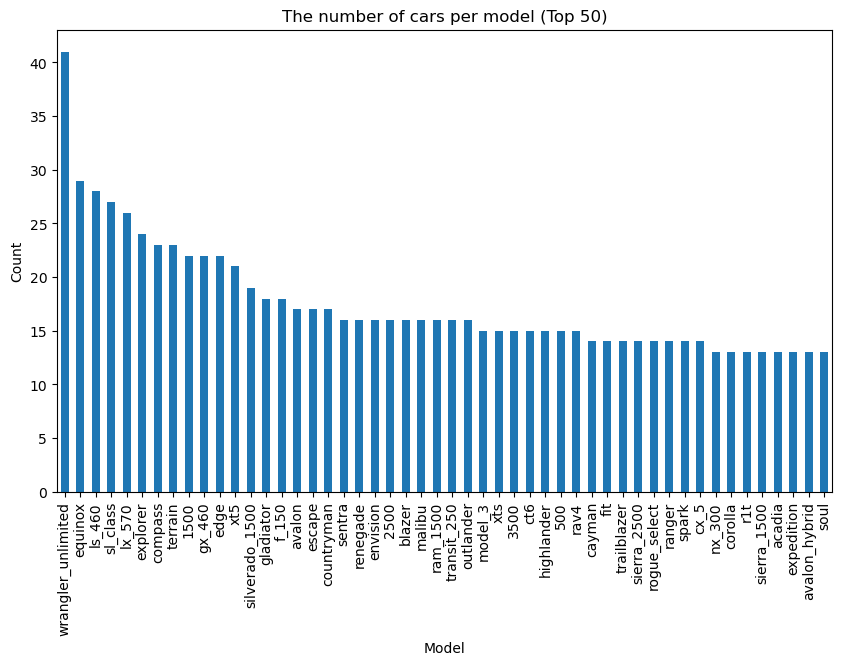

In [21]:
# Count the total number for each model in the train data
model_counts = train['Model'].value_counts()

# Sort by most 
model_counts_sorted = model_counts.sort_values(ascending=False).head(50)

# Drawing graphs
plt.figure(figsize=(10, 6))
model_counts_sorted.plot(kind='bar')
plt.title('The number of cars per model (Top 50)')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

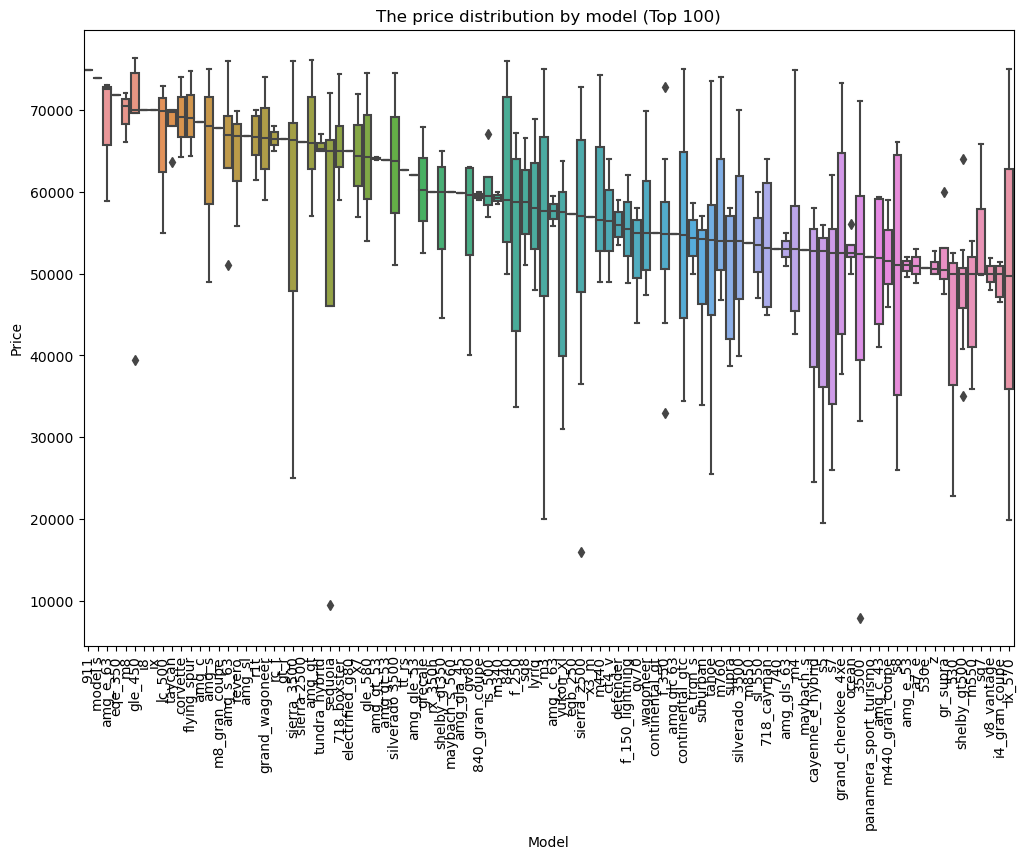

In [22]:

# Sort model by highest price distribution
sorted_models = train.groupby('Model')['Price'].median().sort_values(ascending=False).head(100).index

# Drawing a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Model', y='Price', data=train, order=sorted_models)
plt.title('The price distribution by model (Top 100)')
plt.xlabel('Model')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

#### Comments :

It can be observed that the price distribution for each model is relatively consistent within a certain range. Sorting by the median price of each model, the Porsche 911 Sports model appears to have the highest price 
range, followed by Tesla's Model S. This indicates that the model could be a valuable feature for price prediction.

### 3-2-5 Exterior Color & Interior Color and Price

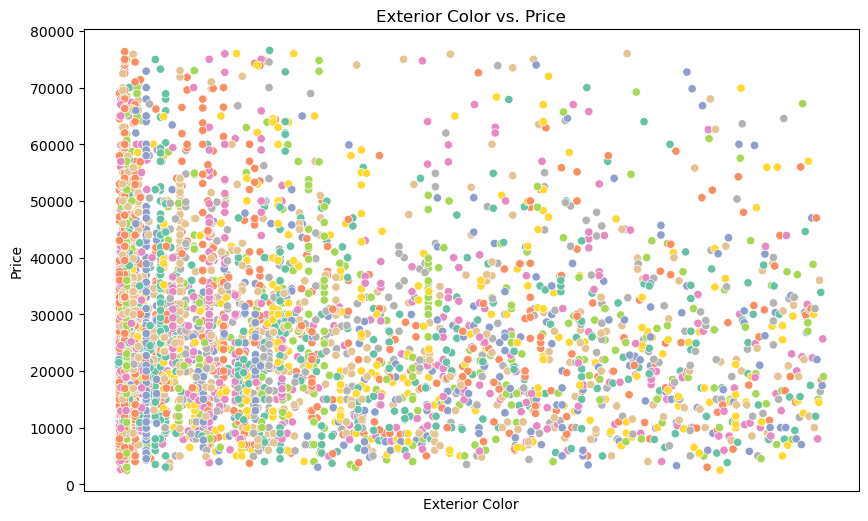

In [23]:
# Draw a scatterplot
plt.figure(figsize=(10, 6)) 
sns.scatterplot(x='Exterior Color', y='Price', hue='Exterior Color', data=train, palette='Set2')
plt.legend().remove()
plt.title('Exterior Color vs. Price')
plt.xlabel('Exterior Color')
plt.ylabel('Price')
plt.xticks([]) 
plt.show()

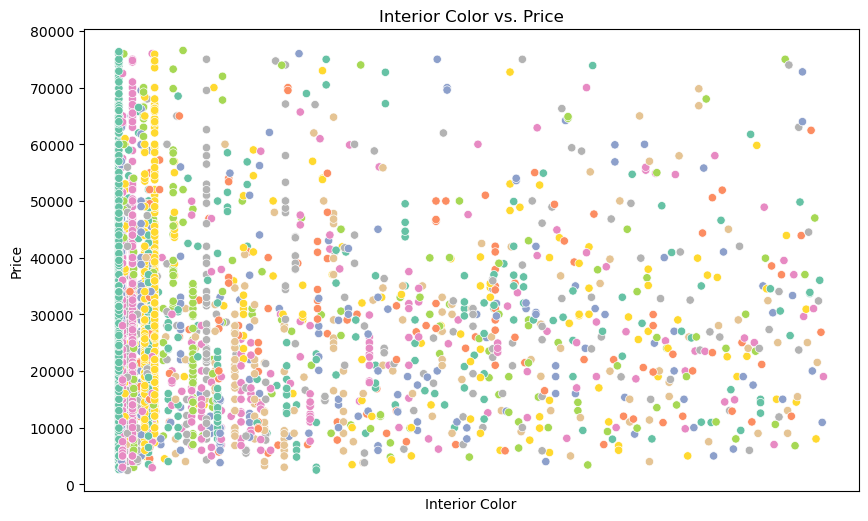

In [24]:
# Draw a scatterplot
plt.figure(figsize=(10, 6)) 
sns.scatterplot(x='Interior Color', y='Price', hue='Interior Color', data=train, palette='Set2')
plt.legend().remove()
plt.title('Interior Color vs. Price')
plt.xlabel('Interior Color')
plt.ylabel('Price')
plt.xticks([]) 
plt.show()

#### Comments :

there is no correlation between exterior color and price, as well as between interior color and price.

### 3-2-6 Drivetrain and Price

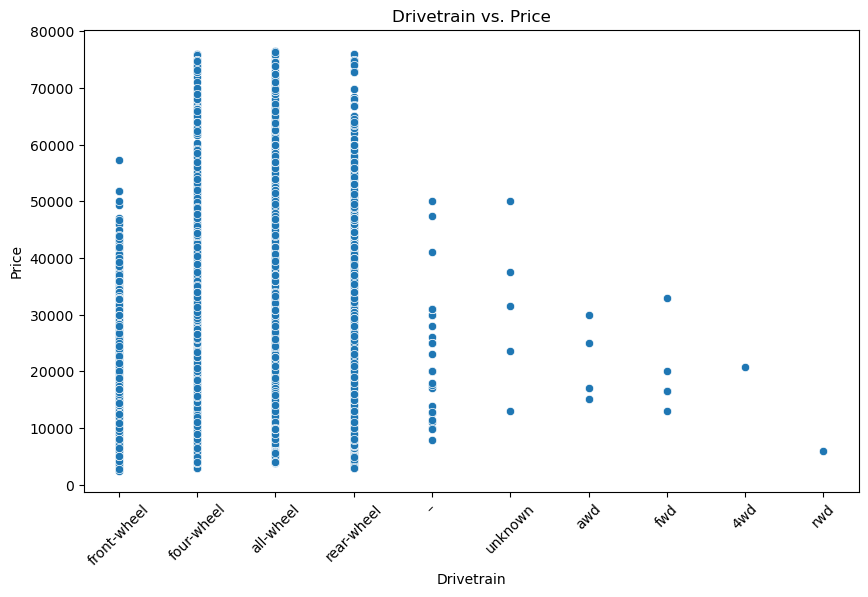

In [25]:
plt.figure(figsize=(10, 6)) 
sns.scatterplot(x='Drivetrain', y='Price', data=train)
plt.title('Drivetrain vs. Price')
plt.xlabel('Drivetrain')
plt.ylabel('Price')
plt.xticks(rotation=45) 
plt.show()

#### Comments :

There is no correlation between Drivetrain and price

### 3-2-6 MPG and Price

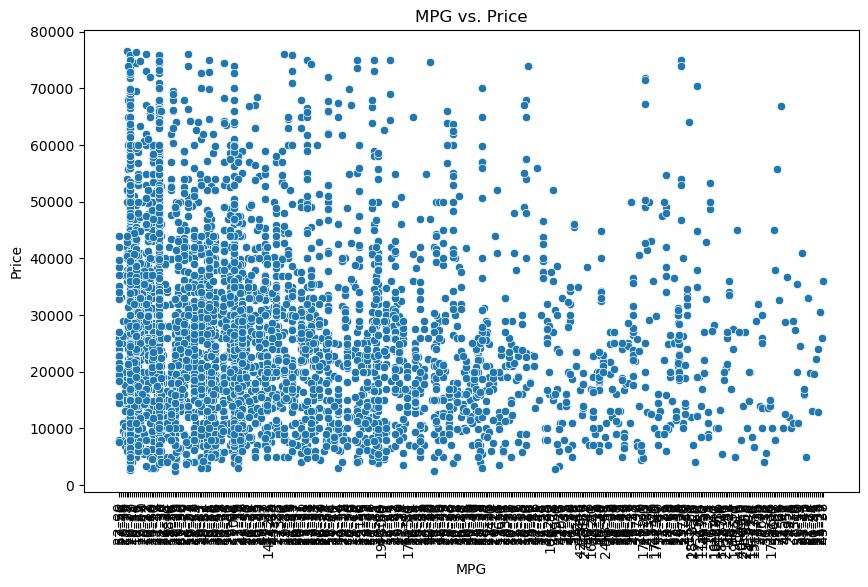

In [26]:
plt.figure(figsize=(10, 6)) 
sns.scatterplot(x='MPG', y='Price', data=train)
plt.title('MPG vs. Price')
plt.xlabel('MPG')
plt.ylabel('Price')
plt.xticks(rotation=90) 
plt.show()

#### Comments :

There is no correlation between MPG and price

### 3-2-7 Fuel Type and Price

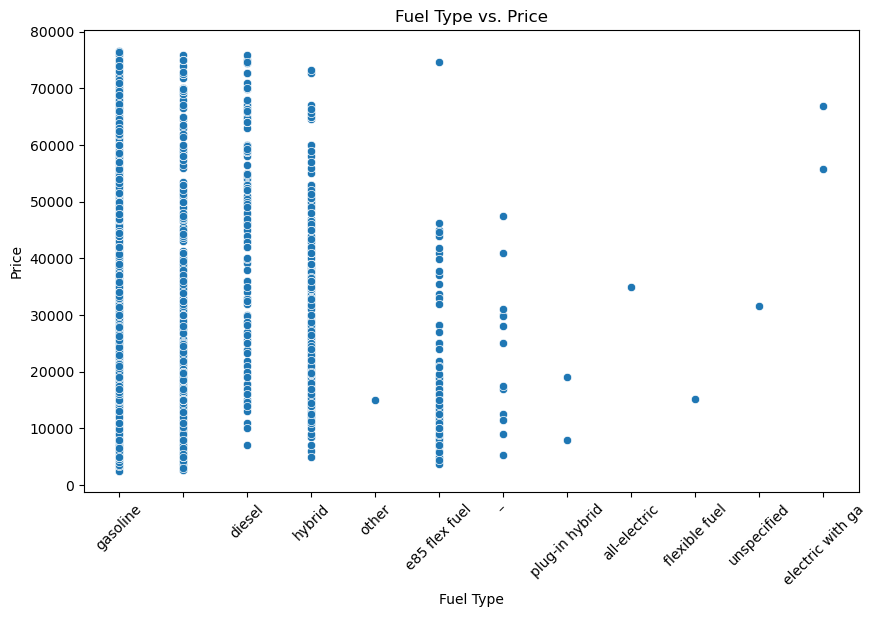

In [27]:
plt.figure(figsize=(10, 6)) 
sns.scatterplot(x='Fuel Type', y='Price', data=train)
plt.title('Fuel Type vs. Price')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.xticks(rotation=45) 
plt.show()

#### Comments :

There is no correlation between Fuel Type and price

### 3-2-8 Transmission and Price

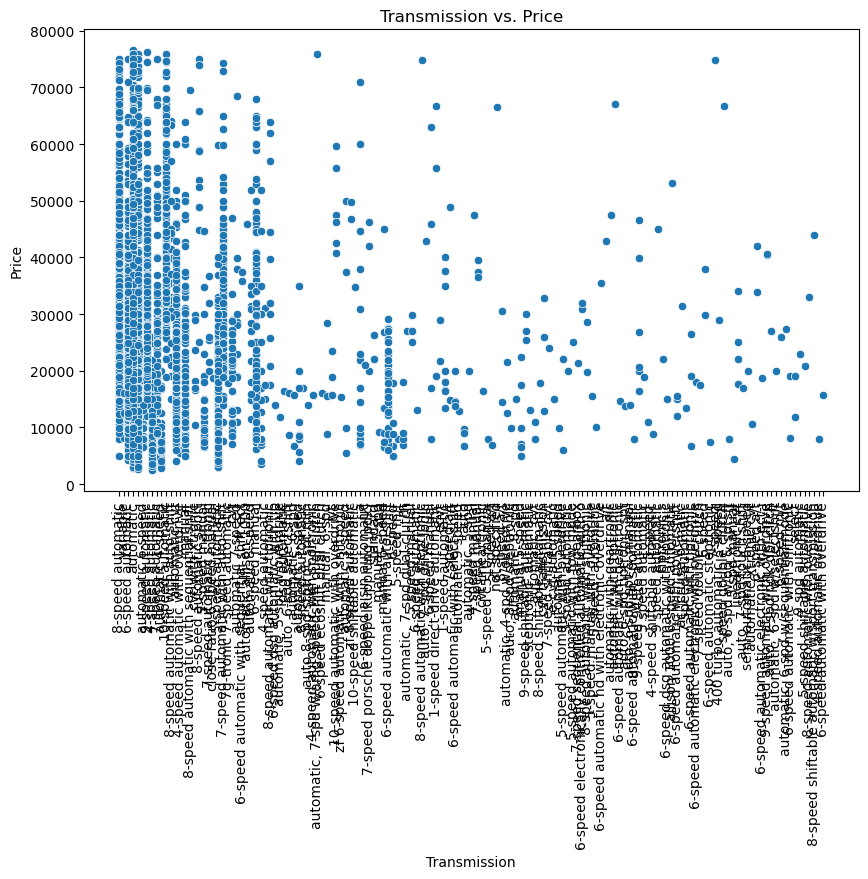

In [28]:
plt.figure(figsize=(10, 6)) 
sns.scatterplot(x='Transmission', y='Price', data=train)
plt.title('Transmission vs. Price')
plt.xlabel('Transmission')
plt.ylabel('Price')
plt.xticks(rotation=90) 
plt.show()

#### Comments :

There is no correlation between Transmission and price

### 3-2-9 Engine and Price

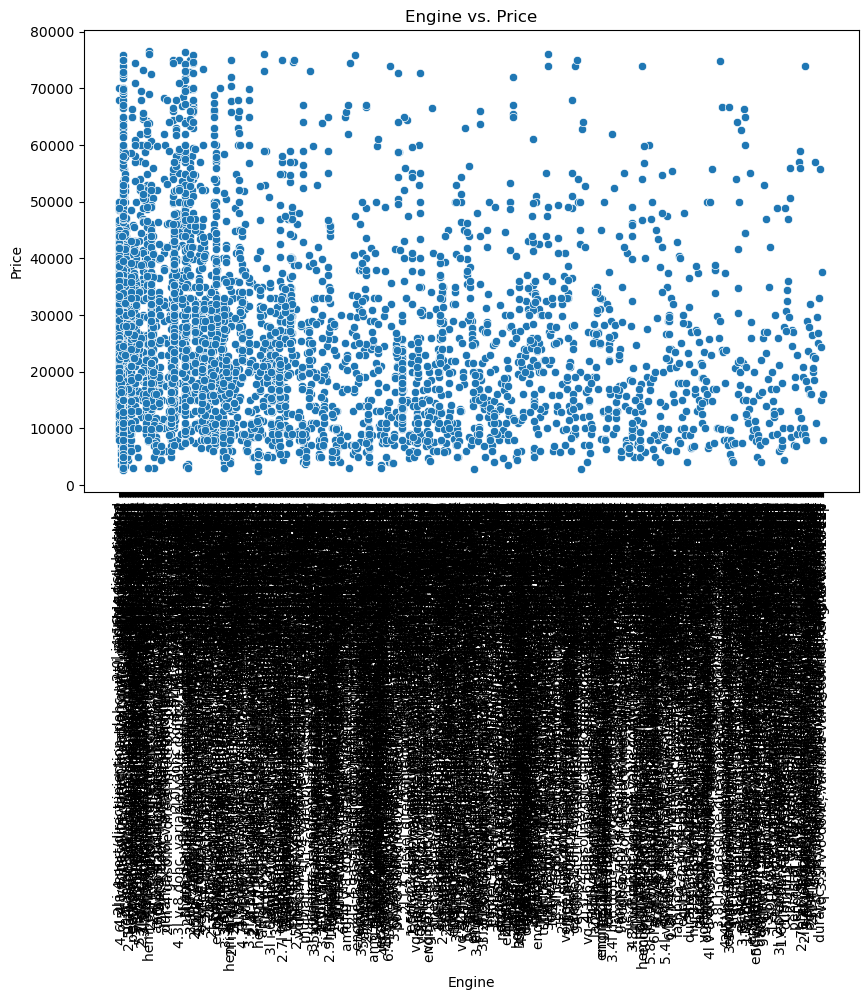

In [29]:
plt.figure(figsize=(10, 6)) 
sns.scatterplot(x='Engine', y='Price', data=train)
plt.title('Engine vs. Price')
plt.xlabel('Engine')
plt.ylabel('Price')
plt.xticks(rotation=90) 
plt.show()

#### Comments :

There is no correlation between Engine and price

### Delete unnecessary columns


In [30]:
train = train.drop(columns=['Bodystyle','Dealer','Exterior Color','Interior Color', 'Drivetrain', 'MPG','Fuel Type','Transmission','Engine']).reset_index(drop=True)

## 4. Feature Engineering

In [31]:
# Divide into numeric and categorical variables
numerical_features = []
categorical_features = []
for f in train.columns:
    if train.dtypes[f] != 'object':
        numerical_features.append(f)
    else:
        categorical_features.append(f)

In [32]:
print("Numerical Features Qty :", len(numerical_features),"\n")
print("Numerical Features : ", numerical_features, "\n\n")
print("Categorical Features Qty :", len(categorical_features),"\n")
print("Categorical Features :", categorical_features)

Numerical Features Qty : 3 

Numerical Features :  ['Year', 'Mileage', 'Price'] 


Categorical Features Qty : 2 

Categorical Features : ['Brand', 'Model']


In [33]:
# Dummy category variable
dummy_cat = pd.get_dummies(train[categorical_features])
dummy_cat.head()

,Brand_acura,Brand_alfa romeo,Brand_alfa_romeo,Brand_aston_martin,Brand_audi,Brand_bentley,Brand_bmw,Brand_buick,Brand_cadillac,Brand_chevrolet,...,Model_yaris,Model_yaris_ia,Model_yaris_sedan,Model_yukon,Model_yukon xl,Model_yukon_xl,Model_z,Model_z3,Model_z4,Model_zdx
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [34]:
# Select by numeric variable
normalize_num = np.log1p(train[numerical_features])
normalize_num.head()

,Year,Mileage,Price
0,7.611842,10.070145,10.085767
1,7.612831,7.988882,10.410847
2,7.609862,11.489411,9.158837
3,7.609367,11.586845,8.845345
4,7.611842,11.025475,10.545341


In [46]:
# Join numeric variable with categoric variable
X_train_0 = normalize_num.join(dummy_cat)

# Seperate price as y value
y_train = X_train_0["Price"]
X_train = X_train_0.drop("Price", axis=1)

In [47]:
# K-ford : 10
k_fold = KFold(n_splits=10, shuffle=True, random_state=2024)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

print("Train Set Count : ", len(X_train1))
print("Test Set Count : ",len(X_test1))


Train Set Count :  3354
Test Set Count :  1119


## 5. Model Training and Evaluation

In [48]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

### Model 1 : LinearRegression 

In [79]:
from sklearn.metrics import mean_squared_error, r2_score

# Fix random seed for reproducibility
np.random.seed(42)

# Convert X_train1 and y_train1 to NumPy arrays if they are not already
X_train1 = np.array(X_train1)
y_train1 = np.array(y_train1)

# Initialize the model
model = LinearRegression()

# Evaluate model performance through cross-validation
rmse_scores = []  # List to store RMSE scores
r2_scores = []    # List to store R-squared scores
for train_index, val_index in k_fold.split(X_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores.append(rmse)
    
    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores.append(r2)

# Calculate average RMSE and R-squared through cross-validation
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)
print("Cross-Validation RMSE: {:.2f}".format(avg_rmse))
print("Cross-Validation R-squared: {:.2f}".format(avg_r2))

# Retrain the model using all training data and evaluate performance on the test set
model.fit(X_train1, y_train1)
test_predictions = model.predict(X_test1)
test_rmse = np.sqrt(mean_squared_error(y_test1, test_predictions))
test_r2 = r2_score(y_test1, test_predictions)
print("Test RMSE: {:.2f}".format(test_rmse))
print("Test R-squared: {:.2f}".format(test_r2))


Cross-Validation RMSE: 326772294316.08
Cross-Validation R-squared: -370357099303566904918016.00
Test RMSE: 642088307528.88
Test R-squared: -955155021065781774385152.00


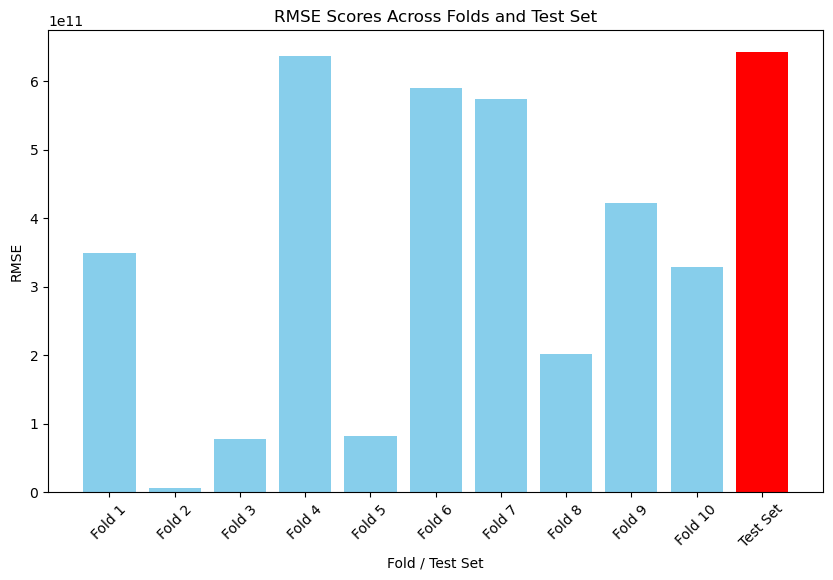

In [80]:
# Concatenate rmse_scores with test_mse
all_rmse = rmse_scores + [test_rmse]

# Create labels for the folds and the test set
fold_labels = [f'Fold {i}' for i in range(1, len(rmse_scores) + 1)]
labels = fold_labels + ['Test Set']

# Plotting RMSE scores
plt.figure(figsize=(10, 6))
colors = ['skyblue'] * len(rmse_scores) + ['red']  # Assign colors to bars
plt.bar(range(1, len(all_rmse) + 1), all_rmse, color=colors)
plt.xticks(range(1, len(all_rmse) + 1), labels, rotation=45)
plt.xlabel('Fold / Test Set')
plt.ylabel('RMSE')
plt.title('RMSE Scores Across Folds and Test Set')
plt.show()


### Model 2 : DecisionTreeRegressor 

In [81]:
from sklearn.tree import DecisionTreeRegressor

# Fix random seed for reproducibility
np.random.seed(42)

# Initialize the model
model = DecisionTreeRegressor()

# Evaluate model performance through cross-validation
rmse_scores = []  # List to store RMSE scores
r2_scores = []    # List to store R-squared scores
for train_index, val_index in k_fold.split(X_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores.append(rmse)
    
    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores.append(r2)

# Calculate average RMSE and R-squared through cross-validation
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)
print("Cross-Validation RMSE: {:.2f}".format(avg_rmse))
print("Cross-Validation R-squared: {:.2f}".format(avg_r2))

# Retrain the model using all training data and evaluate performance on the test set
model.fit(X_train1, y_train1)
test_predictions = model.predict(X_test1)
test_rmse = np.sqrt(mean_squared_error(y_test1, test_predictions))
test_r2 = r2_score(y_test1, test_predictions)
print("Test RMSE: {:.2f}".format(test_rmse))
print("Test R-squared: {:.2f}".format(test_r2))


Cross-Validation RMSE: 0.40
Cross-Validation R-squared: 0.60
Test RMSE: 0.39
Test R-squared: 0.65


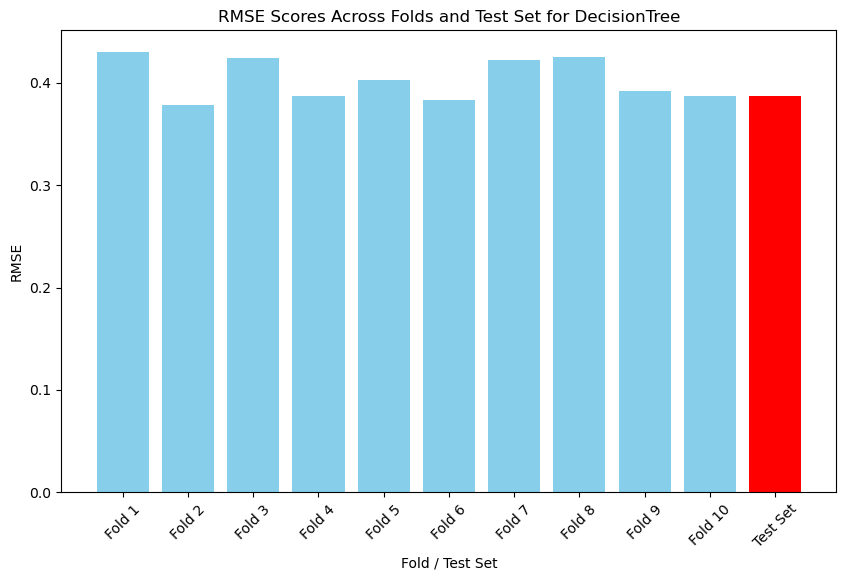

In [82]:
# Concatenate rmse_scores with test_mse
all_rmse = rmse_scores + [test_rmse]

# Create labels for the folds and the test set
fold_labels = [f'Fold {i}' for i in range(1, len(rmse_scores) + 1)]
labels = fold_labels + ['Test Set']

# Plotting RMSE scores
plt.figure(figsize=(10, 6))
colors = ['skyblue'] * len(rmse_scores) + ['red']  # Assign colors to bars
plt.bar(range(1, len(all_rmse) + 1), all_rmse, color=colors)
plt.xticks(range(1, len(all_rmse) + 1), labels, rotation=45)
plt.xlabel('Fold / Test Set')
plt.ylabel('RMSE')
plt.title('RMSE Scores Across Folds and Test Set for DecisionTree')
plt.show()


### Model 3 : RandomForestRegressor 

In [83]:
from sklearn.ensemble import RandomForestRegressor

# Fix random seed for reproducibility
np.random.seed(42)

# Initialize the model
model = RandomForestRegressor()

# Evaluate model performance through cross-validation
rmse_scores = []  # List to store RMSE scores
r2_scores = []    # List to store R-squared scores
for train_index, val_index in k_fold.split(X_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores.append(rmse)
    
    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores.append(r2)

# Calculate average RMSE and R-squared through cross-validation
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)
print("Cross-Validation RMSE: {:.2f}".format(avg_rmse))
print("Cross-Validation R-squared: {:.2f}".format(avg_r2))

# Retrain the model using all training data and evaluate performance on the test set
model.fit(X_train1, y_train1)
test_predictions = model.predict(X_test1)
test_rmse = np.sqrt(mean_squared_error(y_test1, test_predictions))
test_r2 = r2_score(y_test1, test_predictions)
print("Test RMSE: {:.2f}".format(test_rmse))
print("Test R-squared: {:.2f}".format(test_r2))


Cross-Validation RMSE: 0.31
Cross-Validation R-squared: 0.76
Test RMSE: 0.31
Test R-squared: 0.78


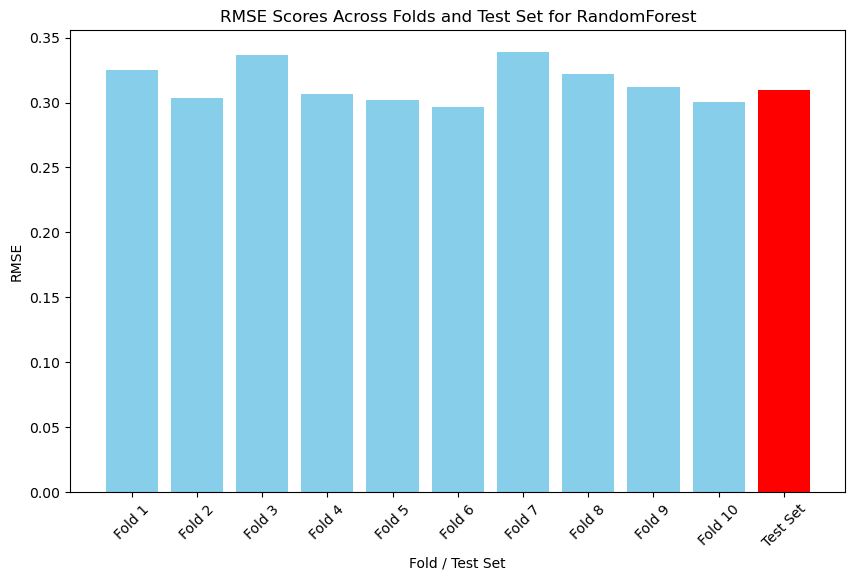

In [84]:
# Concatenate rmse_scores with test_mse
all_rmse = rmse_scores + [test_rmse]

# Create labels for the folds and the test set
fold_labels = [f'Fold {i}' for i in range(1, len(rmse_scores) + 1)]
labels = fold_labels + ['Test Set']

# Plotting RMSE scores
plt.figure(figsize=(10, 6))
colors = ['skyblue'] * len(rmse_scores) + ['red']  # Assign colors to bars
plt.bar(range(1, len(all_rmse) + 1), all_rmse, color=colors)
plt.xticks(range(1, len(all_rmse) + 1), labels, rotation=45)
plt.xlabel('Fold / Test Set')
plt.ylabel('RMSE')
plt.title('RMSE Scores Across Folds and Test Set for RandomForest')
plt.show()


### Model 4 : Support Vector Regression

In [85]:
from sklearn.svm import SVR

# Fix random seed for reproducibility
np.random.seed(42)

# Initialize the model
model = SVR()

# Evaluate model performance through cross-validation
rmse_scores = []  # List to store RMSE scores
r2_scores = []    # List to store R-squared scores
for train_index, val_index in k_fold.split(X_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores.append(rmse)
    
    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores.append(r2)

# Calculate average RMSE and R-squared through cross-validation
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)
print("Cross-Validation RMSE: {:.2f}".format(avg_rmse))
print("Cross-Validation R-squared: {:.2f}".format(avg_r2))

# Retrain the model using all training data and evaluate performance on the test set
model.fit(X_train1, y_train1)
test_predictions = model.predict(X_test1)
test_rmse = np.sqrt(mean_squared_error(y_test1, test_predictions))
test_r2 = r2_score(y_test1, test_predictions)
print("Test RMSE: {:.2f}".format(test_rmse))
print("Test R-squared: {:.2f}".format(test_r2))


Cross-Validation RMSE: 0.41
Cross-Validation R-squared: 0.60
Test RMSE: 0.41
Test R-squared: 0.61


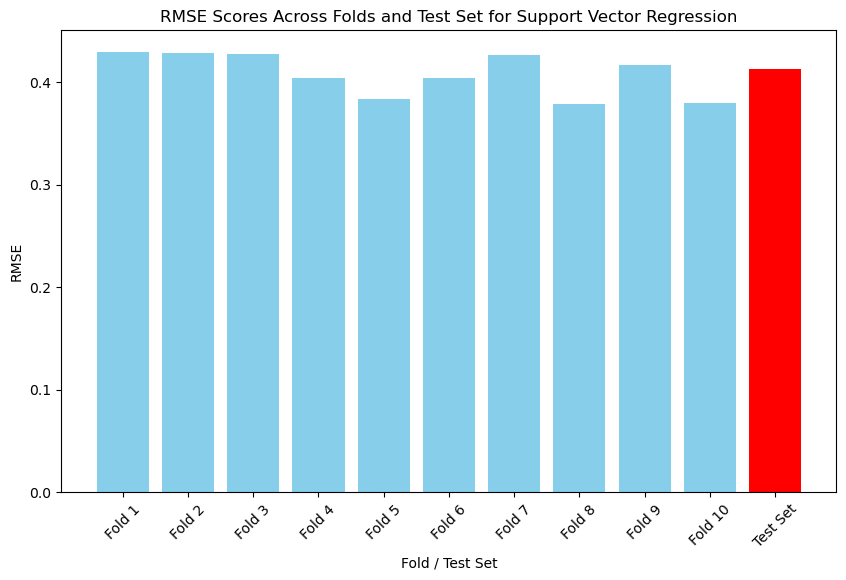

In [86]:
# Concatenate rmse_scores with test_mse
all_rmse = rmse_scores + [test_rmse]

# Create labels for the folds and the test set
fold_labels = [f'Fold {i}' for i in range(1, len(rmse_scores) + 1)]
labels = fold_labels + ['Test Set']

# Plotting RMSE scores
plt.figure(figsize=(10, 6))
colors = ['skyblue'] * len(rmse_scores) + ['red']  # Assign colors to bars
plt.bar(range(1, len(all_rmse) + 1), all_rmse, color=colors)
plt.xticks(range(1, len(all_rmse) + 1), labels, rotation=45)
plt.xlabel('Fold / Test Set')
plt.ylabel('RMSE')
plt.title('RMSE Scores Across Folds and Test Set for Support Vector Regression')
plt.show()


### Model 5 : XGBoost

In [87]:
import xgboost as xgb

# Fix random seed for reproducibility
np.random.seed(42)

# Initialize the model
model = xgb.XGBRegressor()

# Evaluate model performance through cross-validation
rmse_scores = []  # List to store RMSE scores
r2_scores = []    # List to store R-squared scores
for train_index, val_index in k_fold.split(X_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores.append(rmse)
    
    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores.append(r2)

# Calculate average RMSE and R-squared through cross-validation
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)
print("Cross-Validation RMSE: {:.2f}".format(avg_rmse))
print("Cross-Validation R-squared: {:.2f}".format(avg_r2))

# Retrain the model using all training data and evaluate performance on the test set
model.fit(X_train1, y_train1)
test_predictions = model.predict(X_test1)
test_rmse = np.sqrt(mean_squared_error(y_test1, test_predictions))
test_r2 = r2_score(y_test1, test_predictions)
print("Test RMSE: {:.2f}".format(test_rmse))
print("Test R-squared: {:.2f}".format(test_r2))



Cross-Validation RMSE: 0.27
Cross-Validation R-squared: 0.82
Test RMSE: 0.27
Test R-squared: 0.82


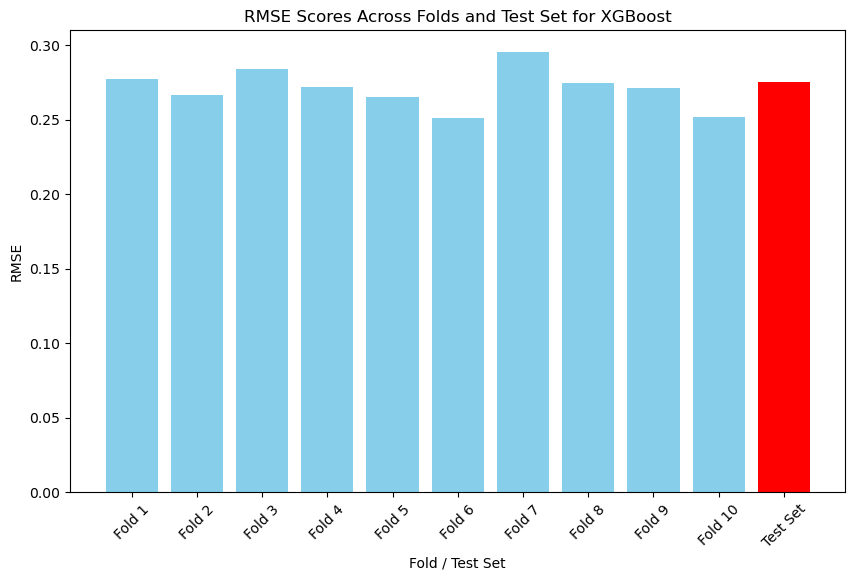

In [88]:
# Concatenate rmse_scores with test_mse
all_rmse = rmse_scores + [test_rmse]

# Create labels for the folds and the test set
fold_labels = [f'Fold {i}' for i in range(1, len(rmse_scores) + 1)]
labels = fold_labels + ['Test Set']

# Plotting RMSE scores
plt.figure(figsize=(10, 6))
colors = ['skyblue'] * len(rmse_scores) + ['red']  # Assign colors to bars
plt.bar(range(1, len(all_rmse) + 1), all_rmse, color=colors)
plt.xticks(range(1, len(all_rmse) + 1), labels, rotation=45)
plt.xlabel('Fold / Test Set')
plt.ylabel('RMSE')
plt.title('RMSE Scores Across Folds and Test Set for XGBoost')
plt.show()


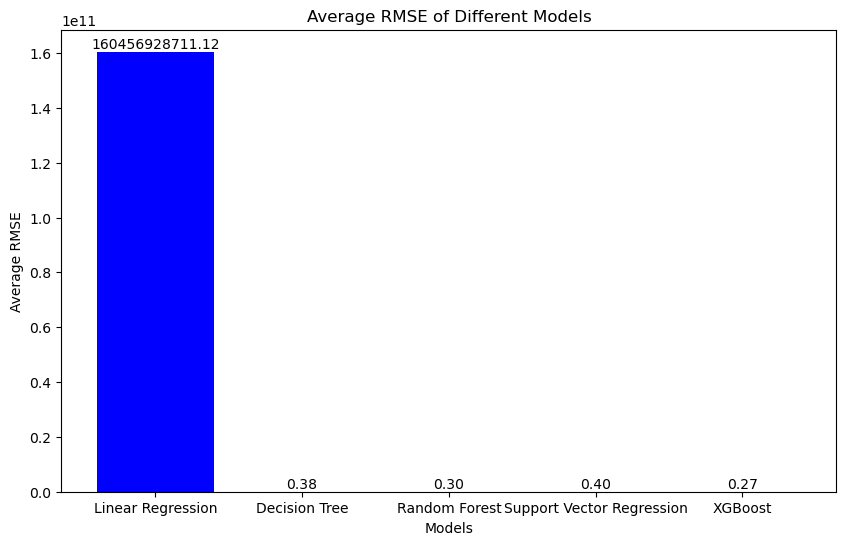

In [37]:
# Fix random seed for reproducibility
np.random.seed(42)

# Define lists to store evaluation metrics
rmse_scores_lr = []
rmse_scores_dt = []
rmse_scores_rf = []
rmse_scores_svr = []
rmse_scores_xgb = []

# Iterate through each fold
for train_index, test_index in k_fold.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit and predict using Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train_fold, y_train_fold)
    lr_pred = lr_model.predict(X_test_fold)
    rmse_lr = mean_squared_error(y_test_fold, lr_pred, squared=False)
    rmse_scores_lr.append(rmse_lr)

    # Fit and predict using Decision Tree
    dt_model = DecisionTreeRegressor()
    dt_model.fit(X_train_fold, y_train_fold)
    dt_pred = dt_model.predict(X_test_fold)
    rmse_dt = mean_squared_error(y_test_fold, dt_pred, squared=False)
    rmse_scores_dt.append(rmse_dt)

    # Fit and predict using Random Forest
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train_fold, y_train_fold)
    rf_pred = rf_model.predict(X_test_fold)
    rmse_rf = mean_squared_error(y_test_fold, rf_pred, squared=False)
    rmse_scores_rf.append(rmse_rf)

    # Fit and predict using Support Vector Regression
    svr_model = SVR()
    svr_model.fit(X_train_fold, y_train_fold)
    svr_pred = svr_model.predict(X_test_fold)
    rmse_svr = mean_squared_error(y_test_fold, svr_pred, squared=False)
    rmse_scores_svr.append(rmse_svr)
    
    # Fit and predict using XGBRegressor
    xgb_model = XGBRegressor()
    xgb_model.fit(X_train_fold, y_train_fold)
    xgb_pred = xgb_model.predict(X_test_fold)
    rmse_xgb = mean_squared_error(y_test_fold, xgb_pred, squared=False)
    rmse_scores_xgb.append(rmse_xgb)

# Calculate mean of RMSE across all folds
mean_rmse_lr = np.mean(rmse_scores_lr)
mean_rmse_dt = np.mean(rmse_scores_dt)
mean_rmse_rf = np.mean(rmse_scores_rf)
mean_rmse_svr = np.mean(rmse_scores_svr)
mean_rmse_xgb = np.mean(rmse_scores_xgb)

# Plotting
labels = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Support Vector Regression', 'XGBoost']
rmse_means = [mean_rmse_lr, mean_rmse_dt, mean_rmse_rf, mean_rmse_svr, mean_rmse_xgb]

plt.figure(figsize=(10, 6))
plt.bar(labels, rmse_means, color=['blue', 'orange', 'green', 'red', 'purple'])

# Adding RMSE values on the bars
for i in range(len(rmse_means)):
    plt.text(i, rmse_means[i], f'{rmse_means[i]:.2f}', ha='center', va='bottom')
    
plt.title('Average RMSE of Different Models')
plt.xlabel('Models')
plt.ylabel('Average RMSE')
plt.show()


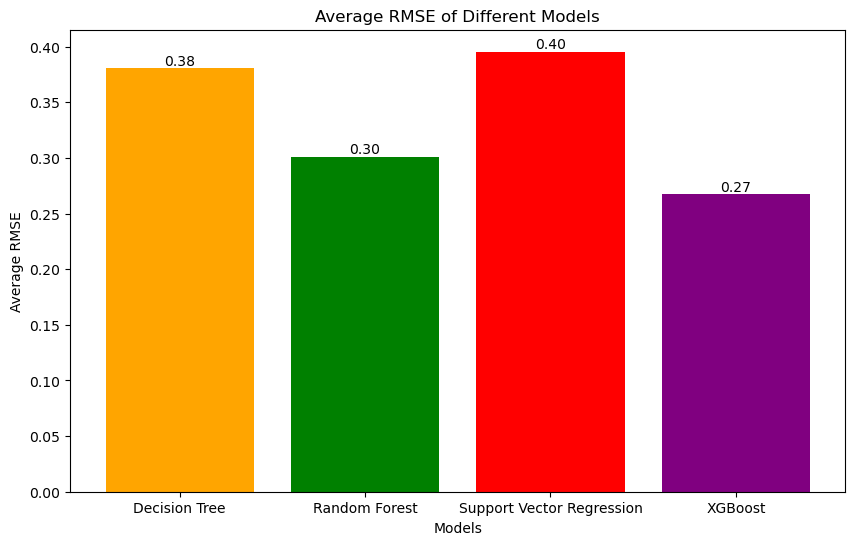

In [38]:
# Plotting
labels = ['Decision Tree', 'Random Forest', 'Support Vector Regression', 'XGBoost']
rmse_means = [mean_rmse_dt, mean_rmse_rf, mean_rmse_svr, mean_rmse_xgb]

plt.figure(figsize=(10, 6))
plt.bar(labels, rmse_means, color=['orange', 'green', 'red', 'purple'])

# Adding RMSE values on the bars
for i in range(len(rmse_means)):
    plt.text(i, rmse_means[i], f'{rmse_means[i]:.2f}', ha='center', va='bottom')
    
plt.title('Average RMSE of Different Models')
plt.xlabel('Models')
plt.ylabel('Average RMSE')
plt.show()

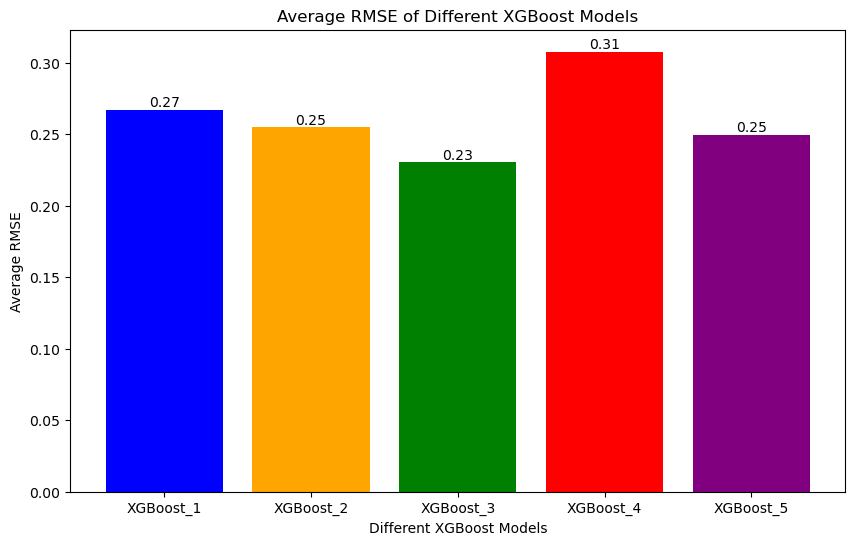

In [52]:
# Define KFold with 10 folds
k_fold = KFold(n_splits=10, shuffle=True, random_state=2024)

# Define lists to store evaluation metrics
rmse_scores_xgb_1 = []
rmse_scores_xgb_2 = []
rmse_scores_xgb_3 = []
rmse_scores_xgb_4 = []
rmse_scores_xgb_5 = []

# Iterate through each fold
for train_index, test_index in k_fold.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Fit and predict using XGBRegressor
    xgb_model_1 = XGBRegressor()
    xgb_model_1.fit(X_train_fold, y_train_fold)
    xgb_pred_1 = xgb_model_1.predict(X_test_fold)
    rmse_xgb_1 = mean_squared_error(y_test_fold, xgb_pred_1, squared=False)
    rmse_scores_xgb_1.append(rmse_xgb_1)
    
    # Fit and predict using XGBRegressor with n_estimators = 100 & learning_rate = 0.5
    xgb_model_2 = XGBRegressor(n_estimators=100, learning_rate=0.5)
    xgb_model_2.fit(X_train_fold, y_train_fold)
    xgb_pred_2 = xgb_model_2.predict(X_test_fold)
    rmse_xgb_2 = mean_squared_error(y_test_fold, xgb_pred_2, squared=False)
    rmse_scores_xgb_2.append(rmse_xgb_2)
    
    
    # Fit and predict using XGBRegressor with n_estimators = 500 & learning_rate = 0.5
    xgb_model_3 = XGBRegressor(n_estimators=500, learning_rate=0.5)
    xgb_model_3.fit(X_train_fold, y_train_fold)
    xgb_pred_3 = xgb_model_3.predict(X_test_fold)
    rmse_xgb_3 = mean_squared_error(y_test_fold, xgb_pred_3, squared=False)
    rmse_scores_xgb_3.append(rmse_xgb_3)
    
    # Fit and predict using XGBRegressor with n_estimators = 100 & learning_rate = 0.1
    xgb_model_4 = XGBRegressor(n_estimators=100, learning_rate=0.1)
    xgb_model_4.fit(X_train_fold, y_train_fold)
    xgb_pred_4 = xgb_model_4.predict(X_test_fold)
    rmse_xgb_4 = mean_squared_error(y_test_fold, xgb_pred_4, squared=False)
    rmse_scores_xgb_4.append(rmse_xgb_4)
    
    
    # Fit and predict using XGBRegressor with n_estimators = 500 & learning_rate = 0.1
    xgb_model_5 = XGBRegressor(n_estimators=500, learning_rate=0.1)
    xgb_model_5.fit(X_train_fold, y_train_fold)
    xgb_pred_5 = xgb_model_5.predict(X_test_fold)
    rmse_xgb_5 = mean_squared_error(y_test_fold, xgb_pred_5, squared=False)
    rmse_scores_xgb_5.append(rmse_xgb_5)
    

# Calculate mean of RMSE across all folds
mean_rmse_xgb_1 = np.mean(rmse_scores_xgb_1)
mean_rmse_xgb_2 = np.mean(rmse_scores_xgb_2)
mean_rmse_xgb_3 = np.mean(rmse_scores_xgb_3)
mean_rmse_xgb_4 = np.mean(rmse_scores_xgb_4)
mean_rmse_xgb_5 = np.mean(rmse_scores_xgb_5)



# Plotting
labels = ['XGBoost_1', 'XGBoost_2', 'XGBoost_3','XGBoost_4','XGBoost_5' ]
rmse_means = [mean_rmse_xgb_1, mean_rmse_xgb_2, mean_rmse_xgb_3, mean_rmse_xgb_4, mean_rmse_xgb_5]

plt.figure(figsize=(10, 6))
plt.bar(labels, rmse_means, color=['blue', 'orange', 'green', 'red','purple'])

# Adding RMSE values on the bars
for i in range(len(rmse_means)):
    plt.text(i, rmse_means[i], f'{rmse_means[i]:.2f}', ha='center', va='bottom')
    
plt.title('Average RMSE of Different XGBoost Models')
plt.xlabel('Different XGBoost Models')
plt.ylabel('Average RMSE')
plt.show()



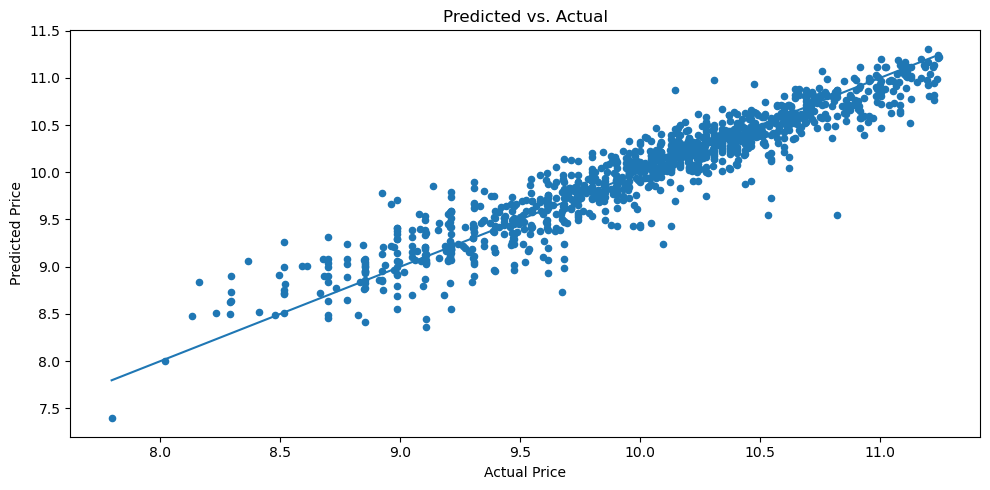

In [47]:
# K-ford : 10
k_fold = KFold(n_splits=10, shuffle=True, random_state=2024)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

xgb_model_3 = XGBRegressor(n_estimators=500, learning_rate=0.5)

# Train model
xgb_model = xgb_model_3.fit(X_train1, y_train1, verbose=False)

# Predict test data set
y_pred = xgb_model.predict(X_test1)

# Drawing regression graph
plt.figure(figsize=(10, 5))
plt.scatter(y_test1, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

In [48]:
# Check the corss validation score
score = cross_val_score(xgb_model_3, X_train, y_train, cv=k_fold, n_jobs=-1, scoring="r2").mean()
print("Score = {0:.5f}".format(score))

Score = 0.87288


### Predict Used_Car Values

In [77]:
brand = 'honda'
model = 'odyssey'
year = int(2016)
mileage = int(75000)

target = pd.DataFrame(columns=[X_train1.columns])

In [78]:
brand_index = 0
for col in X_train1.columns:
    if col == 'Brand' + "_" + brand:
        break;
    brand_index += 1
brand_index

19

In [79]:
# Check the index location of the selected used car model in the variable column data frame
model_index = 0
for col in X_train1.columns:
    if col == 'Model' + "_" + model:
        break;
    model_index += 1
    
model_index

637

In [80]:
# Array of zeros
target_list = np.zeros_like(X_train1.iloc[0])

In [81]:
# Put the number 1 in the selected brand and model locations in the data frame
target_list[brand_index] = 1
target_list[model_index] = 1

In [82]:
# Put the year and miles in the data frame
target_list[0] = year
target_list[1] = mileage

In [83]:
# Convert all elements in target_list with 0 being False and 1 being True
transformed_values = [True if x == 1 else False for x in target_list[2:]]
target_list = [target_list[0], target_list[1]] + transformed_values

In [84]:
# Insert data into target data frame
for i in range(1):
    target.loc[i] = target_list

In [85]:
numerical_features = ['Year', 'Mileage']

In [86]:
target[numerical_features]

,Year,Mileage
0,2016,75000


In [87]:
# Convert the values in the Year and Mileage columns to float form and apply the log1p function
normalize_target = target[numerical_features].astype(float).apply(np.log1p)
print(normalize_target)

       Year    Mileage
0  7.609367  11.225257


In [88]:
# After deleting the Year and Mileage columns, combine them with the normalize_target dataframe to create target_goal.
target.drop(['Year', 'Mileage'], axis=1, level=0, inplace=True)
target_goal = normalize_target.join(target)
target_goal

,Year,Mileage,Brand_acura,Brand_alfa romeo,Brand_alfa_romeo,Brand_aston_martin,Brand_audi,Brand_bentley,Brand_bmw,Brand_buick,...,Model_yaris,Model_yaris_ia,Model_yaris_sedan,Model_yukon,Model_yukon xl,Model_yukon_xl,Model_z,Model_z3,Model_z4,Model_zdx
0,7.609367,11.225257,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [89]:
# Predicted logged price
price_log = xgb_model_3.predict(target_goal)

In [90]:
# Revert the logged price back to its original price
price = np.exp(price_log)
print(f"Brand : {brand.upper()}")
print(f"Model : {model.upper()}")
print(f"Year  : {year}")
print(f"Mileage  : {mileage}")
print(f"Estimated Price : ${int(price)}")

Brand : HONDA
Model : ODYSSEY
Year  : 2016
Mileage  : 75000
Estimated Price : $19155


### Compare same model with different years

In [95]:
# Find the average of the same model for each year
actual_car_info = train[["Brand", "Model", "Year", "Mileage", "Price"]]

same_model = actual_car_info[actual_car_info["Model"]== model] 
same_model_at_dataset = same_model[["Brand","Model","Year","Mileage","Price"]]
same_model_at_dataset_by_year = same_model_at_dataset.groupby("Year").agg({'Price':np.mean}).astype('int')
same_model_at_dataset_by_year = same_model_at_dataset_by_year.reset_index()
same_model_at_dataset_by_year

,Year,Price
0,2018,23931
1,2019,27993
2,2023,46998


In [96]:
same_model_at_dataset

,Brand,Model,Year,Mileage,Price
552,honda,odyssey,2019,25891,28991
1672,honda,odyssey,2019,50425,26995
1968,honda,odyssey,2023,1408,46998
2856,honda,odyssey,2018,66368,23931
